# Group-level satistical analysis of brain electrical properties - Experiment n°3
This notebook presents the third experiment of the group level statistical analysis of brain electrical properties ($\sigma$ and $\epsilon_r$). In this experiment, we investigated the confounding effects of brain mean diffusivity (MD) and relative ventricle volume (RVV) on the association between brain conductivity and post-menstrual age (PMA). $n = 662$ neonatal data point were included, as brain MD was not available in all neonatal dHCP sessions. 

It has previously been demonstrated by various studies that conductivity at $128$ MHz (i.e. 3T) is predominantly related to water content, which is known to also decrease during neonatal development. We utilised brain MD as a surrogate for water content in our multivariate analysis. This assumes a linear relationship between MD and water content during the neonatal period.

Measured brain tissue conductivity is potentially confounded by adjacent CSF which is known to have a very high conductivity ($\sigma_{\textrm{CSF}} = 2.14$ [$\textrm{S.m}^{-1}$] at $128$ MHz, IT'IS tissue EPs database https://itis.swiss/virtual-population/tissue-properties/database/dielectric-properties/). Due to the low spatial resolution of our measurements plus smoothing effects during processing, signal from CSF could be mixed into the average brain tissue conductivity values reported. Within the brain, CSF is contained within the ventricle system, so we used RVV obtained from image segmentation, as a confounding variable.

Part of nano-eptk package by Arnaud Boutillon (arnaud.boutillon@kcl.ac.uk).

## Python environment setting

In [1]:
import os
import sys
import warnings

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from scipy.stats import pearsonr
from matplotlib.ticker import FormatStrFormatter

base_dir = os.path.abspath(os.path.join(os.path.pardir, os.path.pardir))
sys.path.append(os.path.join(base_dir))

from utils.stats import *
from utils.plots import *

sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")

## 1. Filter MD and RVV covariates
Remove subjects for which MD was not available.

In [2]:
def filter_dHCP_df(input_df_path, output_df_path):
    # Remove NaN
    df = pd.read_csv(input_df_path)
    df = df.dropna(subset=["brain_MD", "RVV"])
    df.to_csv(output_df_path, index=False)

In [3]:
# Set file path
csv_dir = os.path.join(base_dir, "data", "cohorts_csv")
unfiltered_df_path = os.path.join(csv_dir, "dHCP.csv")
df_path = os.path.join(csv_dir, "dHCP_filtered_MD_RVV.csv")

# Filter and load dataframe
filter_dHCP_df(unfiltered_df_path, df_path)
df = pd.read_csv(df_path) 

# Display cohort size
print(f"dHCP session n = {len(df.index)}")
print(f"dHCP subjects m = {df['subject_id'].nunique()}")

dHCP session n = 662
dHCP subjects m = 596


## 2. Relationships between brain conductivity and developmental variables in neonatal cohort
We assessed the relationships between dHCP variables (conductivity, PMA, MD and RVV) using Pearson's correlation coefficients $\rho_{XY}$.

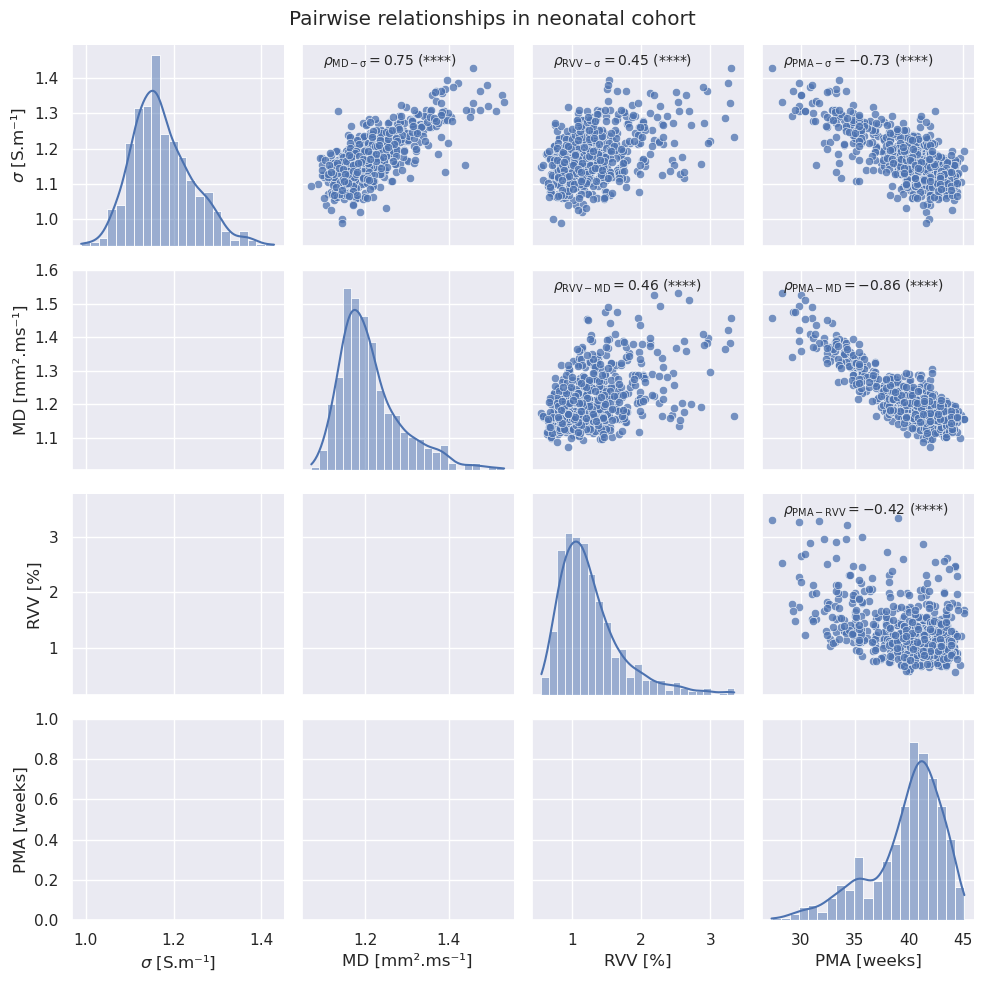

In [4]:
# Set file path
plot_dir = os.path.join(base_dir, "plots", "experiments")
plot_path = os.path.join(plot_dir, "experiment3A.png")

# Load dataframe
df = pd.read_csv(df_path) 

# Select cols
cols = ["brain_SIG", "brain_MD", "RVV", "PMA"]
df = df[cols]

# Rename columns for plotting
df = df.rename(columns={
    "brain_SIG": r"$\sigma$ [S.m⁻¹]",
    "brain_MD": "MD [mm².ms⁻¹]",
    "RVV": "RVV [%]",
    "PMA": "PMA [weeks]",
})

# Initialize plot
g = sns.PairGrid(df)
g.fig.suptitle(f"Pairwise relationships in neonatal cohort")

# Plot data
g.map_diag(sns.histplot, kde=True)
g.map_upper(sns.scatterplot, alpha=0.75)
g.map_upper(annotate_pairplot)

# Adjust layout
g.fig.tight_layout()

# Save plot
output_dir = os.path.dirname(plot_path)
os.makedirs(output_dir, exist_ok=True)
plt.savefig(plot_path, dpi=300, bbox_inches="tight")

The correlation matrix showed that there was a strong and significant Pearson correlation coefficient between $\sigma$ and brain MD. This is consistent with known relationship between conductivity and MD via water content. Both conductivity and MD were negatively associated with PMA, which is related to the decrease in water content as the brain develops. In our experiments, MD was found to be more strongly correlated with development than conductivity, this could be explained by conductivity measurements being more noisy than MD measurements. For its part, RVV was also correlated with PMA; as the brain develops, there is a decrease in relative ventricular spaces (or conversely, an increase in brain tissue volume relative to intracranial volume). Conductivity was also mildly associated with RVV, indeed artefacts associated to higher CSF $\sigma$ values are present due to pre-processing smoothing and partial volume effect. Incidentally, we observed a moderate correlation between MD and RVV which suggests that larger ventricles are associated with higher diffusivity (possibly reflecting less mature tissue or more free water).

## 3. Correction for MD and RVV confounding effects on the association between brain conductivity and PMA

### 3.a. Multivariate mixed-effects statistical analysis
We employed multivariate analysis to control for the confounding effects of MD and RVV variables, by creating a LME model that included the following predictors: PMA, MD and RVV. We used mixed-effects to account for within-subject correlation between repeated sessions. Proportional effect coefficients (e.g. $\tilde{\beta}_\textrm{PMA}$) were computed by building the same LME model with $z$-score normalised response and predictor variables. These coefficients were used as effect sizes for each regressor.

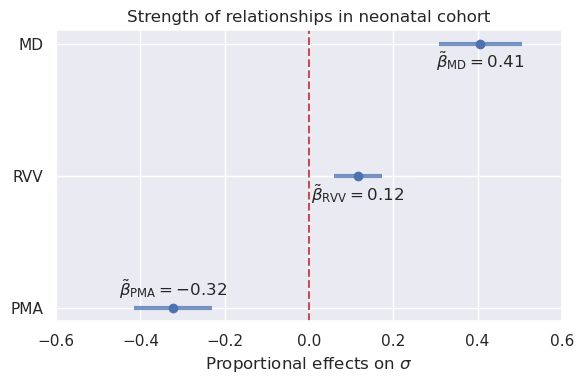

In [5]:
# Set file path
summary_dir = os.path.join(base_dir, "statsmodels")
plot_path = os.path.join(plot_dir, "experiment3B.png")
summary_path = os.path.join(summary_dir, "experiment3B.txt")

# Load dataframe
df = pd.read_csv(df_path) 

# Date header
y_col = "brain_SIG"
x_cols = ["PMA", "RVV", "brain_MD"]
groups_col = "subject_id"

# Center data
for x_col in x_cols:
    df[x_col] -= df[x_col].mean()

# Fit mixed effects model
formula = f"{y_col} ~  {' + '.join(x_cols)}"
lme = smf.mixedlm(formula=formula, data=df, groups=df[groups_col]).fit(reml=False)

# Coefficients of determination
marginal_r2, conditional_r2 = lme_coefficient_determination(lme, df)

# Normalize data
df[y_col] = (df[y_col] - df[y_col].mean()) / df[y_col].std()
for x_col in x_cols:
    df[x_col] /= df[x_col].std()

# Fit mixed effects model (proportional effects)
lme_prop = smf.mixedlm(formula=formula, data=df, groups=df[groups_col]).fit(reml=False)

# Coefficient of determination
marginal_r2_prop, conditional_r2_prop = lme_coefficient_determination(lme_prop, df)

# Labels
params = lme_prop.params[1:-1]
yticks = ["PMA", "RVV", "MD"]
xlim = [-.6, .6]

# Initialize plot
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
ax.set_title("Strength of relationships in neonatal cohort")

# Plot proportional effects
ax.scatter(params, range(len(params)), color="b", zorder=2)

# Iter over predictor
for idx, ci in enumerate(lme_prop.conf_int().loc[params.index].iterrows()):
    # Add the confidence interval error bars
    ax.hlines(idx, ci[1][0], ci[1][1], color="b", zorder=1, linewidth=3, alpha=0.75)

    # Label
    va = "top" if idx > 0 else "bottom"
    y = idx - 0.05 if idx > 0 else idx + 0.05
    a = rf"\tilde{{\beta}}_{{\mathregular{{{yticks[idx]}}}}}"
    ax.text(params[idx], y, f"${a} = {params[idx]:.2f}$", va=va, ha="center")

# Add dashed line at 0.0
plt.axline((0,0), (0,1), color="r", linestyle="--")

# Axis labels and linits
ax.set_yticks(range(len(params)), yticks)
ax.set_xlabel(r"Proportional effects on $\sigma$")
ax.set_xlim(xlim)

# Adjust layout
fig.tight_layout()

# Initialize directories
for path in [summary_path, plot_path]:
    output_dir = os.path.dirname(path)
    os.makedirs(output_dir, exist_ok=True)
    
# Save plot
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    
# Write summary
with open(summary_path, "w") as fh:
    fh.write(lme.summary().as_text())
    fh.write(f"\nMarginal R² = {marginal_r2:.2f}, Conditional R² = {conditional_r2:.2f}\n\n")
    fh.write(lme_prop.summary().as_text())
    fh.write(f"\nMarginal R² = {marginal_r2_prop:.2f}, Conditional R² = {conditional_r2_prop:.2f}\n\n")

In [6]:
# Model summary
f = open(summary_path, 'r')
file_contents = f.read()
print(file_contents)
f.close()

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: brain_SIG
No. Observations: 662     Method:             ML       
No. Groups:       596     Scale:              0.0013   
Min. group size:  1       Log-Likelihood:     1136.0399
Max. group size:  2       Converged:          Yes      
Mean group size:  1.1                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    1.174    0.002 668.285 0.000  1.170  1.177
PMA         -0.007    0.001  -6.841 0.000 -0.008 -0.005
RVV          0.017    0.004   4.060 0.000  0.009  0.025
brain_MD     0.365    0.045   8.172 0.000  0.277  0.452
Group Var    0.001    0.009                            

Marginal R² = 0.59, Conditional R² = 0.72

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: brain_SIG
No. Observations: 662 

Multivariate mixed-effects linear regression found that brain $\sigma$ still correlates significantly with PMA, decreasing by $\hat{\beta}_{\textrm{PMA}} = -0.007 \pm 0.001\, [\textrm{S.m}^{-1}\textrm{week}^{-1}]$, after accounting for MD and RVV. This is lower than $\hat{\beta}_{\textrm{PMA}} = -0.015 \pm 0.001\, [\textrm{S.m}^{-1}\textrm{week}^{-1}]$ from the univariate model. Analysis of the proportional effect coefficients indicated that MD has a strong positive effect on $\sigma$ while PMA has a moderate negative effect ($\tilde{\beta}_{\textrm{MD}} = 0.41$, $\textit{p} < 0.0001$; $\tilde{\beta}_{\textrm{PMA}} = -0.32$, $\textit{p} < 0.0001$).

### 3.b. Partial correlations
Partial correlation coefficients $\rho_{XY \cdot \textbf{Z}}$ were computed using the residuals $e(X|\textbf{Z})$ and $e(Y|\textbf{Z})$ that were obtained by respectively fitting LME models on $X$ and $Y$ variables with $\textbf{Z}$ as predictors. We used these to assess the strength of the relationship between the two variables while controlling the effect of confounding variables.

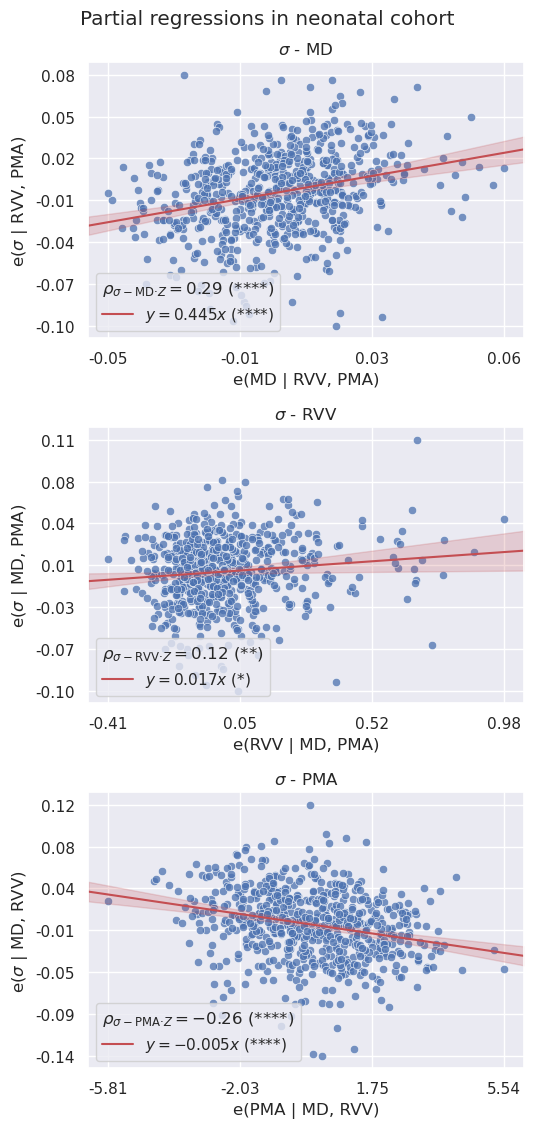

In [7]:
# Set path 
plot_path = os.path.join(plot_dir, "experiment3C.png")

# Load dataframe
df = pd.read_csv(df_path) 

# Data header
y_col = "brain_SIG"
x_cols = ["brain_MD", "RVV", "PMA"]
groups_col = "subject_id"
y_label = r"$\sigma$"
x_labels = ["MD", "RVV", "PMA"]
n = len(x_cols)

# Initialize plot
fig, axes = plt.subplots(3, 1, figsize=(5.5,11.5))
fig.suptitle("Partial regressions in neonatal cohort")

# Iter over predictors
for i, x_col in enumerate(x_cols):
    # Control variables
    z_cols = [z_col for z_col in x_cols if z_col != x_col]     

    # Partial regression on x
    x_res_col = f"{x_col}_residual"
    formula = f"{x_col} ~  {' + '.join(z_cols)}"
    lme = smf.mixedlm(formula=formula, data=df, groups=df[groups_col]).fit(reml=False)
    df[x_res_col] = lme.resid

    # Partial regression on y
    y_res_col = f"{y_col}_residual"
    formula = f"{y_col} ~  {' + '.join(z_cols)}"
    lme = smf.mixedlm(formula=formula, data=df, groups=df[groups_col]).fit(reml=False)
    df[y_res_col] = lme.resid
    
    # Axis limit with margin
    xlim = calculate_plot_lim(df[x_res_col], coeff_margin=0.05)

    # Fit mixed effects model on residuals
    formula = f"{y_res_col} ~  {x_res_col}"
    lme = smf.mixedlm(formula=formula, data=df, groups=df[groups_col]).fit(reml=False)

    # Confidence interval
    pred_df = lme_confidence_interval(lme, df, x_res_col, xlim)
    
    # Plot data
    sns.scatterplot(ax=axes[i], data=df, x=x_res_col, y=y_res_col, alpha=0.75)
    
    # Label
    slope = lme.params[x_res_col]
    pval = lme.pvalues[x_res_col]
    label = f"$y = {slope:.3f}x$ ({convert_pvalue_to_asterisks(pval)})"
    
    # Regression line and confidence interval
    axes[i].plot(pred_df[x_res_col], pred_df["Predicted"], color="r", label=label)
    axes[i].fill_between(pred_df[x_res_col], pred_df["CI_lower"], pred_df["CI_upper"], color="r", alpha=0.2)
    
    # Correlation
    rho, pval = pearsonr(df[x_res_col], df[y_res_col])
    
    # Set title and labels
    axes[i].set_title(f"{y_label} - {x_labels[i]}")
    axes[i].set_xlabel(f"e({x_labels[i]} | {', '.join([x_labels[j] for j in range(n) if j != i])})")
    axes[i].set_ylabel(f"e({y_label} | {', '.join([x_labels[j] for j in range(n) if j != i])})")
    axes[i].set_xlim(xlim)

    # Axes ticks and limits
    xlim = calculate_plot_lim(df[x_res_col], coeff_margin=0)
    ylim = calculate_plot_lim(df[y_res_col], coeff_margin=0)
    axes[i].set_xticks(np.linspace(xlim[0], xlim[1], 4))
    axes[i].set_yticks(np.linspace(ylim[0], ylim[1], 7))
    axes[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Legend
    var_symbol = rf"\rho_{{\sigma-\mathregular{{{x_labels[i]}}}·Z}}"
    leg = axes[i].legend(loc="lower left", title=f"${var_symbol} = {rho:.2f}$ ({convert_pvalue_to_asterisks(pval)})")
    leg._legend_box.align = "left"

# Adjust layout
fig.tight_layout()
    
# Save plot
output_dir = os.path.dirname(plot_path)
os.makedirs(output_dir, exist_ok=True)
plt.savefig(plot_path, bbox_inches='tight', dpi=300)

Partial correlation ($\rho_{\sigma-\textrm{PMA} \cdot \textbf{Z}} = - 0.26$, $\textit{p} < 0.0001$) confirmed the presence of a residual correlation between $\sigma$ and PMA when controlling for the confounding effects of MD and RVV. This also showed that the strength of the relationship between $\sigma$ and PMA decreases when controlling for other variables, confirming the confounding effects of the control variables. In addition, MD is confirmed to be a major independent determinant of $\sigma$ and the minor but significant partial correlation between RVV and $\sigma$ may reflect residual error due CSF signal propagation. Ultimately, the largest contributor to conductivity variance is MD, but PMA still explains additional, non-redundant variance.

Hence the data suggest that while the decline in brain conductivity over the perinatal period is predominantly attributable to a decrease in water content, there is a residual additional age dependence effect that remains unexplained by change in water content alone.